In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
import seaborn as sns
import re
import random

# optuna

!pip install optuna
import optuna.integration.lightgbm as lgb
import optuna

In [3]:
Tourney_Compact_Results  = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MNCAATourneyCompactResults.csv')

Tourney_Seeds = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MNCAATourneySeeds.csv')

RegularSeason_Compact_Results = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MRegularSeasonCompactResults.csv')
MSeasons = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MSeasons.csv')
MTeams = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MTeams.csv')
massey = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MMasseyOrdinals.csv')


test = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MSampleSubmissionStage1.csv')

In [ ]:
R_df_season.fillna(0, inplace=True)

In [ ]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [ ]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [14]:
Tourney_Compact_Results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [11]:
random.seed(1)

def change(data):
  for index in data.index:
    if random.randint(0, 1) == 1:


      data.at[index, 'WLoc'] = data.at[index, 'WTeamID']
      data.at[index, 'WTeamID'] = data.at[index, 'LTeamID']
      data.at[index, 'LTeamID'] = data.at[index, 'WLoc']


      data.at[index, 'WLoc'] = data.at[index, 'WScore']
      data.at[index, 'WScore'] = data.at[index, 'LScore']
      data.at[index, 'LScore'] = data.at[index, 'WLoc']

  return data


In [20]:
df = change(Tourney_Compact_Results)

In [21]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1234,54,1116,63,63,0
1,1985,136,1345,58,1120,59,59,0
2,1985,136,1250,43,1207,68,68,0
3,1985,136,1425,55,1229,58,58,0
4,1985,136,1325,38,1242,49,49,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,71,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1277,51,1403,61,61,0
2249,2019,152,1438,63,1120,62,62,0


In [24]:
# target作成

df['ScoreDiff'] = df['WScore'] - df['LScore']
df['Win'] = (df['ScoreDiff'] > 0).astype(int)

df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreDiff,Win
0,1985,136,1234,54,1116,63,63,0,-9,0
1,1985,136,1345,58,1120,59,59,0,-1,0
2,1985,136,1250,43,1207,68,68,0,-25,0
3,1985,136,1425,55,1229,58,58,0,-3,0
4,1985,136,1325,38,1242,49,49,0,-11,0
...,...,...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,71,1,6,1
2247,2019,146,1277,68,1181,67,N,0,1,1
2248,2019,152,1277,51,1403,61,61,0,-10,0
2249,2019,152,1438,63,1120,62,62,0,1,1


In [26]:
test

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5
...,...,...
11385,2019_1449_1459,0.5
11386,2019_1449_1463,0.5
11387,2019_1458_1459,0.5
11388,2019_1458_1463,0.5


In [27]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))

In [28]:
test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [30]:
# modelingで使用する特徴量の選択をする
# 学習させるときは、Training_dataとTest_dataのカラム名を合わせる！！
# 学習に必要な特徴量の名前をリストに加える

features = [
            'Season',
           'SeedA',
           'SeedB',
#           'Wrank',
#           'Lrank',
 #          'W_match_count',
 #          'L_match_count'
           ]

In [31]:
# sclase 正規化の関数  df_trainは学習させたいデータ df_testは、予測で使用するテストデータ

def rescale(features, df_train, df_test=None):
    train_min = df_train[features].min()
    train_max = df_train[features].max()
    
    df_train[features] = (df_train[features] - train_min) / (train_max - train_min)

    if df_test is not None:
      test_min = df_test[features].min()
      test_max = df_test[features].max()
      df_test[features] = (df_test[features] - test_min) / (test_max - test_min)

      return df_train[features], df_test[features]
        
    return df_train[features]

In [32]:
# 例

#df_rescale, test_rescale = rescale(features, df, test)



In [ ]:
# optunaと交差検証用のデータセットをそれぞれ作成
# optunaで使用するデータセットとk_fold(交差検証)で使用するデータセットの二つを用意する

#　交差検証用のデータセット

X = df
test = df_test

# optuna用のデータセット
# rescaleしてます

X1 = df
X1 = rescale(features, X1)

y = df['WinA']

display(X1)
display(y)

,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,1.000000,1.000000,0.128857,0.000000,0.368421,0.296754,0.500000,0.380218,0.311979
1,0.000000,1.000000,0.830827,0.715636,0.455535,0.383398,0.000000,0.687646,0.710504
2,0.600000,0.400000,0.401089,0.452298,0.673321,0.513420,0.600000,0.363884,0.461274
3,0.666667,0.333333,0.673321,0.430072,0.808612,0.713858,0.666667,0.432354,0.320196
4,0.466667,0.533333,0.564428,0.385620,0.368421,0.375174,0.466667,0.598004,0.506619
...,...,...,...,...,...,...,...,...,...
1110,0.066667,0.266667,0.712919,0.597643,0.582043,0.565128,0.400000,0.565438,0.520601
1111,0.000000,0.066667,0.767802,0.747119,0.721362,0.661811,0.466667,0.523220,0.554051
1112,0.066667,0.133333,0.721362,0.661811,0.703947,0.678517,0.466667,0.508707,0.489415
1113,0.266667,0.000000,0.582043,0.565128,0.851974,0.774193,0.633333,0.365035,0.367538


0       1
1       1
2       1
3       1
4       1
       ..
1110    0
1111    0
1112    0
1113    0
1114    0
Name: WinA, Length: 2230, dtype: int64

In [ ]:
# Optuna用の交差検証のためのtrainデータとtestデータの作成


train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.30, random_state=1)



In [ ]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2,5)
    n_estimators =  trial.suggest_int('n_estimators', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split',2,10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,10)
    random_state  = trial.suggest_int('random_state', 1, 10)

    clf = RandomForestClassifier(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
                                 min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,
                                 n_jobs=2,random_state=random_state)
    
    clf.fit(train_x,train_y)
    clf_probs = clf.predict_proba(test_x)

    score = log_loss(test_y, clf_probs)
    print(score)

    return score


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-03-07 03:01:30,112] A new study created in memory with name: no-name-048219ef-a1fe-4640-9d86-6e8ddb645635
[I 2021-03-07 03:01:30,335] Trial 0 finished with value: 0.5786256424645088 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 9}. Best is trial 0 with value: 0.5786256424645088.


0.5786256424645088


[I 2021-03-07 03:01:30,555] Trial 1 finished with value: 0.5995787370700179 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 23, 'min_samples_split': 6, 'min_samples_leaf': 5, 'random_state': 5}. Best is trial 0 with value: 0.5786256424645088.


0.5995787370700179


[I 2021-03-07 03:01:30,773] Trial 2 finished with value: 0.5695807604953543 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 14, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 5}. Best is trial 2 with value: 0.5695807604953543.


0.5695807604953543


[I 2021-03-07 03:01:30,993] Trial 3 finished with value: 0.5849365031027817 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'random_state': 4}. Best is trial 2 with value: 0.5695807604953543.


0.5849365031027817


[I 2021-03-07 03:01:31,215] Trial 4 finished with value: 0.5846062398357202 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 17, 'min_samples_split': 4, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 2 with value: 0.5695807604953543.


0.5846062398357202


[I 2021-03-07 03:01:31,439] Trial 5 finished with value: 0.5748364547664574 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 8}. Best is trial 2 with value: 0.5695807604953543.


0.5748364547664574


[I 2021-03-07 03:01:31,657] Trial 6 finished with value: 0.587294211222958 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'random_state': 4}. Best is trial 2 with value: 0.5695807604953543.
[I 2021-03-07 03:01:31,770] Trial 7 finished with value: 0.6190722795386254 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 2, 'n_estimators': 1, 'min_samples_split': 2, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 2 with value: 0.5695807604953543.


0.587294211222958
0.6190722795386254


[I 2021-03-07 03:01:31,996] Trial 8 finished with value: 0.5707295994812043 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 4, 'n_estimators': 18, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 3}. Best is trial 2 with value: 0.5695807604953543.


0.5707295994812043


[I 2021-03-07 03:01:32,214] Trial 9 finished with value: 0.569790818623866 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 5, 'min_samples_split': 10, 'min_samples_leaf': 8, 'random_state': 9}. Best is trial 2 with value: 0.5695807604953543.


0.569790818623866


[I 2021-03-07 03:01:32,447] Trial 10 finished with value: 0.5742175203721035 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 29, 'min_samples_split': 4, 'min_samples_leaf': 3, 'random_state': 7}. Best is trial 2 with value: 0.5695807604953543.


0.5742175203721035


[I 2021-03-07 03:01:32,673] Trial 11 finished with value: 0.5706187961065593 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 3, 'min_samples_split': 10, 'min_samples_leaf': 7, 'random_state': 10}. Best is trial 2 with value: 0.5695807604953543.


0.5706187961065593


[I 2021-03-07 03:01:32,899] Trial 12 finished with value: 0.5665855400909008 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 11, 'min_samples_split': 10, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 12 with value: 0.5665855400909008.


0.5665855400909008


[I 2021-03-07 03:01:33,126] Trial 13 finished with value: 0.5662182901797679 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 12, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5662182901797679


[I 2021-03-07 03:01:33,355] Trial 14 finished with value: 0.5790958495346868 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 13, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 7}. Best is trial 13 with value: 0.5662182901797679.


0.5790958495346868


[I 2021-03-07 03:01:33,585] Trial 15 finished with value: 0.5662182901797679 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 12, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5662182901797679


[I 2021-03-07 03:01:33,818] Trial 16 finished with value: 0.5701456508377587 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5701456508377587


[I 2021-03-07 03:01:34,048] Trial 17 finished with value: 0.5703833290096377 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 12, 'min_samples_split': 8, 'min_samples_leaf': 9, 'random_state': 7}. Best is trial 13 with value: 0.5662182901797679.


0.5703833290096377


[I 2021-03-07 03:01:34,283] Trial 18 finished with value: 0.6002806690306167 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 16, 'min_samples_split': 9, 'min_samples_leaf': 7, 'random_state': 4}. Best is trial 13 with value: 0.5662182901797679.


0.6002806690306167


[I 2021-03-07 03:01:34,519] Trial 19 finished with value: 0.6022877507937848 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 2, 'n_estimators': 20, 'min_samples_split': 9, 'min_samples_leaf': 9, 'random_state': 8}. Best is trial 13 with value: 0.5662182901797679.


0.6022877507937848


[I 2021-03-07 03:01:34,746] Trial 20 finished with value: 0.5720552364819111 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 10, 'min_samples_split': 7, 'min_samples_leaf': 8, 'random_state': 1}. Best is trial 13 with value: 0.5662182901797679.


0.5720552364819111


[I 2021-03-07 03:01:34,974] Trial 21 finished with value: 0.5681731032619283 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5681731032619283


[I 2021-03-07 03:01:35,204] Trial 22 finished with value: 0.5662182901797679 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 12, 'min_samples_split': 10, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5662182901797679


[I 2021-03-07 03:01:35,437] Trial 23 finished with value: 0.5695807604953543 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 14, 'min_samples_split': 9, 'min_samples_leaf': 9, 'random_state': 5}. Best is trial 13 with value: 0.5662182901797679.


0.5695807604953543


[I 2021-03-07 03:01:35,661] Trial 24 finished with value: 0.5841495326027908 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 5, 'min_samples_split': 8, 'min_samples_leaf': 10, 'random_state': 7}. Best is trial 13 with value: 0.5662182901797679.


0.5841495326027908


[I 2021-03-07 03:01:35,893] Trial 25 finished with value: 0.5741865897479214 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'random_state': 8}. Best is trial 13 with value: 0.5662182901797679.


0.5741865897479214


[I 2021-03-07 03:01:36,123] Trial 26 finished with value: 0.5712504104245415 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 15, 'min_samples_split': 7, 'min_samples_leaf': 9, 'random_state': 6}. Best is trial 13 with value: 0.5662182901797679.


0.5712504104245415


[I 2021-03-07 03:01:36,350] Trial 27 finished with value: 0.5688928589813629 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 12, 'min_samples_split': 9, 'min_samples_leaf': 8, 'random_state': 5}. Best is trial 13 with value: 0.5662182901797679.


0.5688928589813629


[I 2021-03-07 03:01:36,586] Trial 28 finished with value: 0.5655761791548357 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 18, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 4}. Best is trial 28 with value: 0.5655761791548357.


0.5655761791548357


[I 2021-03-07 03:01:36,822] Trial 29 finished with value: 0.5699349300844483 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 4, 'n_estimators': 19, 'min_samples_split': 7, 'min_samples_leaf': 6, 'random_state': 3}. Best is trial 28 with value: 0.5655761791548357.


0.5699349300844483


[I 2021-03-07 03:01:37,056] Trial 30 finished with value: 0.5675544523909903 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 26, 'min_samples_split': 8, 'min_samples_leaf': 9, 'random_state': 3}. Best is trial 28 with value: 0.5655761791548357.


0.5675544523909903


[I 2021-03-07 03:01:37,283] Trial 31 finished with value: 0.5743972219565884 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 8, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 4}. Best is trial 28 with value: 0.5655761791548357.


0.5743972219565884


[I 2021-03-07 03:01:37,511] Trial 32 finished with value: 0.5686882747511142 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 16, 'min_samples_split': 10, 'min_samples_leaf': 10, 'random_state': 5}. Best is trial 28 with value: 0.5655761791548357.


0.5686882747511142


[I 2021-03-07 03:01:37,742] Trial 33 finished with value: 0.5655407556951207 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 22, 'min_samples_split': 9, 'min_samples_leaf': 10, 'random_state': 6}. Best is trial 33 with value: 0.5655407556951207.


0.5655407556951207


[I 2021-03-07 03:01:37,974] Trial 34 finished with value: 0.5998536995427005 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 22, 'min_samples_split': 8, 'min_samples_leaf': 9, 'random_state': 5}. Best is trial 33 with value: 0.5655407556951207.


0.5998536995427005


[I 2021-03-07 03:01:38,211] Trial 35 finished with value: 0.5640689120402863 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 4}. Best is trial 35 with value: 0.5640689120402863.


0.5640689120402863


[I 2021-03-07 03:01:38,447] Trial 36 finished with value: 0.5701119180474475 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'n_estimators': 29, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 4}. Best is trial 35 with value: 0.5640689120402863.


0.5701119180474475


[I 2021-03-07 03:01:38,692] Trial 37 finished with value: 0.5710782019091172 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 26, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5710782019091172


[I 2021-03-07 03:01:38,925] Trial 38 finished with value: 0.565120493186041 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 3}. Best is trial 35 with value: 0.5640689120402863.


0.565120493186041


[I 2021-03-07 03:01:39,163] Trial 39 finished with value: 0.5699817184684082 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'n_estimators': 26, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 3}. Best is trial 35 with value: 0.5640689120402863.


0.5699817184684082


[I 2021-03-07 03:01:39,402] Trial 40 finished with value: 0.5812199988611924 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 24, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5812199988611924


[I 2021-03-07 03:01:39,642] Trial 41 finished with value: 0.565517248360226 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 22, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 4}. Best is trial 35 with value: 0.5640689120402863.


0.565517248360226


[I 2021-03-07 03:01:39,877] Trial 42 finished with value: 0.565517248360226 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 22, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 4}. Best is trial 35 with value: 0.5640689120402863.


0.565517248360226


[I 2021-03-07 03:01:40,116] Trial 43 finished with value: 0.5654324290063781 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5654324290063781


[I 2021-03-07 03:01:40,358] Trial 44 finished with value: 0.5656044330658037 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5656044330658037


[I 2021-03-07 03:01:40,596] Trial 45 finished with value: 0.5650020797770416 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 3}. Best is trial 35 with value: 0.5640689120402863.


0.5650020797770416


[I 2021-03-07 03:01:40,833] Trial 46 finished with value: 0.566220077565529 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 3}. Best is trial 35 with value: 0.5640689120402863.


0.566220077565529


[I 2021-03-07 03:01:41,071] Trial 47 finished with value: 0.5654324290063781 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5654324290063781


[I 2021-03-07 03:01:41,306] Trial 48 finished with value: 0.5705460159463777 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5705460159463777


[I 2021-03-07 03:01:41,547] Trial 49 finished with value: 0.6048388316585762 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'n_estimators': 27, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.6048388316585762


[I 2021-03-07 03:01:41,784] Trial 50 finished with value: 0.5654324290063781 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5654324290063781


[I 2021-03-07 03:01:42,020] Trial 51 finished with value: 0.5654324290063781 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5654324290063781


[I 2021-03-07 03:01:42,265] Trial 52 finished with value: 0.5665994297949967 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2}. Best is trial 35 with value: 0.5640689120402863.


0.5665994297949967


[I 2021-03-07 03:01:42,503] Trial 53 finished with value: 0.566220077565529 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'random_state': 3}. Best is trial 35 with value: 0.5640689120402863.


0.566220077565529


[I 2021-03-07 03:01:42,747] Trial 54 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:42,985] Trial 55 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:43,221] Trial 56 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:43,465] Trial 57 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:43,709] Trial 58 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:43,950] Trial 59 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:44,193] Trial 60 finished with value: 0.5685645261069406 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 4, 'n_estimators': 30, 'min_samples_split': 7, 'min_samples_leaf': 6, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5685645261069406


[I 2021-03-07 03:01:44,434] Trial 61 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:44,680] Trial 62 finished with value: 0.5648029628488763 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 29, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5648029628488763


[I 2021-03-07 03:01:44,917] Trial 63 finished with value: 0.5651988874028275 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5651988874028275


[I 2021-03-07 03:01:45,162] Trial 64 finished with value: 0.5645394199991467 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 30, 'min_samples_split': 7, 'min_samples_leaf': 6, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5645394199991467


[I 2021-03-07 03:01:45,403] Trial 65 finished with value: 0.5648029628488763 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 29, 'min_samples_split': 7, 'min_samples_leaf': 6, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5648029628488763


[I 2021-03-07 03:01:45,646] Trial 66 finished with value: 0.5641956677206219 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 6, 'min_samples_leaf': 6, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5641956677206219


[I 2021-03-07 03:01:45,888] Trial 67 finished with value: 0.5641956677206219 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5641956677206219


[I 2021-03-07 03:01:46,126] Trial 68 finished with value: 0.5641956677206219 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'random_state': 1}. Best is trial 35 with value: 0.5640689120402863.


0.5641956677206219


[I 2021-03-07 03:01:46,367] Trial 69 finished with value: 0.5633064770619612 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'random_state': 10}. Best is trial 69 with value: 0.5633064770619612.


0.5633064770619612


[I 2021-03-07 03:01:46,604] Trial 70 finished with value: 0.5777733197386967 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'random_state': 9}. Best is trial 69 with value: 0.5633064770619612.


0.5777733197386967


[I 2021-03-07 03:01:46,841] Trial 71 finished with value: 0.5660257362984376 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'random_state': 2}. Best is trial 69 with value: 0.5633064770619612.


0.5660257362984376


[I 2021-03-07 03:01:47,082] Trial 72 finished with value: 0.5632835326213715 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 4, 'min_samples_leaf': 7, 'random_state': 10}. Best is trial 72 with value: 0.5632835326213715.


0.5632835326213715


[I 2021-03-07 03:01:47,319] Trial 73 finished with value: 0.5685667130753844 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 28, 'min_samples_split': 4, 'min_samples_leaf': 7, 'random_state': 9}. Best is trial 72 with value: 0.5632835326213715.


0.5685667130753844


[I 2021-03-07 03:01:47,558] Trial 74 finished with value: 0.5630862944314882 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 4, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 74 with value: 0.5630862944314882.


0.5630862944314882


[I 2021-03-07 03:01:47,801] Trial 75 finished with value: 0.5630862944314882 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 27, 'min_samples_split': 4, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 74 with value: 0.5630862944314882.


0.5630862944314882


[I 2021-03-07 03:01:48,036] Trial 76 finished with value: 0.5626760856333423 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 26, 'min_samples_split': 4, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5626760856333423


[I 2021-03-07 03:01:48,272] Trial 77 finished with value: 0.562929633385566 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 26, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.562929633385566


[I 2021-03-07 03:01:48,511] Trial 78 finished with value: 0.562929633385566 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 26, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.562929633385566


[I 2021-03-07 03:01:48,746] Trial 79 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5627583442219645


[I 2021-03-07 03:01:48,987] Trial 80 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5627583442219645


[I 2021-03-07 03:01:49,223] Trial 81 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5627583442219645


[I 2021-03-07 03:01:49,456] Trial 82 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5627583442219645


[I 2021-03-07 03:01:49,693] Trial 83 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 76 with value: 0.5626760856333423.


0.5627583442219645


[I 2021-03-07 03:01:49,930] Trial 84 finished with value: 0.5661254386641118 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 9}. Best is trial 76 with value: 0.5626760856333423.


0.5661254386641118


[I 2021-03-07 03:01:50,168] Trial 85 finished with value: 0.5617851939139011 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5617851939139011


[I 2021-03-07 03:01:50,404] Trial 86 finished with value: 0.5620823662518496 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 21, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5620823662518496


[I 2021-03-07 03:01:50,643] Trial 87 finished with value: 0.5685139852164262 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 21, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 9}. Best is trial 85 with value: 0.5617851939139011.


0.5685139852164262


[I 2021-03-07 03:01:50,881] Trial 88 finished with value: 0.5671428541092425 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 9, 'random_state': 9}. Best is trial 85 with value: 0.5617851939139011.


0.5671428541092425


[I 2021-03-07 03:01:51,117] Trial 89 finished with value: 0.5617851939139011 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 23, 'min_samples_split': 2, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5617851939139011


[I 2021-03-07 03:01:51,353] Trial 90 finished with value: 0.5662386847352973 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 4, 'n_estimators': 23, 'min_samples_split': 2, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5662386847352973


[I 2021-03-07 03:01:51,591] Trial 91 finished with value: 0.5627583442219645 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5627583442219645


[I 2021-03-07 03:01:51,826] Trial 92 finished with value: 0.5620823662518496 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 21, 'min_samples_split': 3, 'min_samples_leaf': 9, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5620823662518496


[I 2021-03-07 03:01:52,067] Trial 93 finished with value: 0.5627631325292374 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 9, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5627631325292374


[I 2021-03-07 03:01:52,300] Trial 94 finished with value: 0.5685139852164262 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 9, 'random_state': 9}. Best is trial 85 with value: 0.5617851939139011.


0.5685139852164262


[I 2021-03-07 03:01:52,542] Trial 95 finished with value: 0.5617851939139011 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.5617851939139011


[I 2021-03-07 03:01:52,784] Trial 96 finished with value: 0.5671428541092425 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 23, 'min_samples_split': 3, 'min_samples_leaf': 9, 'random_state': 9}. Best is trial 85 with value: 0.5617851939139011.


0.5671428541092425


[I 2021-03-07 03:01:53,025] Trial 97 finished with value: 0.563109635759301 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 19, 'min_samples_split': 2, 'min_samples_leaf': 9, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.563109635759301


[I 2021-03-07 03:01:53,270] Trial 98 finished with value: 0.566916515173815 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 21, 'min_samples_split': 3, 'min_samples_leaf': 8, 'random_state': 10}. Best is trial 85 with value: 0.5617851939139011.


0.566916515173815


[I 2021-03-07 03:01:53,514] Trial 99 finished with value: 0.569124295758469 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 5, 'n_estimators': 22, 'min_samples_split': 2, 'min_samples_leaf': 8, 'random_state': 8}. Best is trial 85 with value: 0.5617851939139011.


0.569124295758469


In [ ]:
best_params = study.best_params

print("Best params", best_params)

for key, value in best_params.items():
  print("   {}: {}".format(key,value))

Best params {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 5, 'n_estimators': 20, 'min_samples_split': 80, 'min_samples_leaf': 94, 'random_state': 62}
   criterion: entropy
   bootstrap: True
   max_depth: 3
   max_features: auto
   max_leaf_nodes: 5
   n_estimators: 20
   min_samples_split: 80
   min_samples_leaf: 94
   random_state: 62


In [ ]:
X

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,0,1.000000,1.000000,0.128857,0.000000,0.368421,0.296754,0.500000,0.380218,0.311979,8,1
1,2003,136,1112,80,1436,51,0,0.000000,1.000000,0.830827,0.715636,0.455535,0.383398,0.000000,0.687646,0.710504,29,1
2,2003,136,1113,84,1272,71,0,0.600000,0.400000,0.401089,0.452298,0.673321,0.513420,0.600000,0.363884,0.461274,13,1
3,2003,136,1141,79,1166,73,0,0.666667,0.333333,0.673321,0.430072,0.808612,0.713858,0.666667,0.432354,0.320196,6,1
4,2003,136,1143,76,1301,74,0,0.466667,0.533333,0.564428,0.385620,0.368421,0.375174,0.466667,0.598004,0.506619,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,4,0.066667,0.266667,0.712919,0.597643,0.582043,0.565128,0.400000,0.565438,0.520601,-6,0
1111,2019,146,1181,67,1277,68,4,0.000000,0.066667,0.767802,0.747119,0.721362,0.661811,0.466667,0.523220,0.554051,-1,0
1112,2019,152,1277,51,1403,61,0,0.066667,0.133333,0.721362,0.661811,0.703947,0.678517,0.466667,0.508707,0.489415,-10,0
1113,2019,152,1120,62,1438,63,0,0.266667,0.000000,0.582043,0.565128,0.851974,0.774193,0.633333,0.365035,0.367538,-1,0


In [ ]:
test_pred = []


kf = KFold(n_splits=5, shuffle=True, random_state=1)

for year in test['Season'].unique():


  X_year = X[X['Season'] < year].copy()

  # 予測するターゲットのカラム名を変更してもらう

  y_year = X_year['WinA'].copy()

  test_year = test[test['Season'] == year].copy()

  X_year, test_year = rescale(features, X_year, test_year)

  clf_val_pred = np.zeros(len(y_year))
  clf_test_pred = np.zeros(len(test_year))
  logloss = []

  for trn_idx , val_idx in kf.split(X_year,y_year):
    x_train_idx = X_year.iloc[trn_idx]
    y_train_idx = y_year.iloc[trn_idx]
    x_valid_idx = X_year.iloc[val_idx]
    y_valid_idx = y_year.iloc[val_idx]

    crf = RandomForestClassifier(bootstrap = study.best_params['bootstrap'], criterion = study.best_params['criterion'],
                                     max_depth = study.best_params['max_depth'], max_features = study.best_params['max_features'],
                                     max_leaf_nodes = study.best_params['max_leaf_nodes'],n_estimators = study.best_params['n_estimators'],
                                     min_samples_split = study.best_params['min_samples_split'],min_samples_leaf = study.best_params['min_samples_leaf'],
                                     random_state=study.best_params['random_state'])


    clf = RandomForestClassifier(**best_params)
    clf.fit(x_train_idx, y_train_idx)
    clf_test_pred += clf.predict(test_year)/5

    logloss.append(log_loss(y_valid_idx, clf.predict(x_valid_idx)))

  test_pred += clf_test_pred.tolist()

  print('Year_Predict:',year,'Log_Loss:', np.mean(logloss))

Year_Predict: 2015 Log_Loss: 10.605309351340704
Year_Predict: 2016 Log_Loss: 10.378153128477386
Year_Predict: 2017 Log_Loss: 10.505610542777358
Year_Predict: 2018 Log_Loss: 10.47439014982281
Year_Predict: 2019 Log_Loss: 10.299147868918253


[0.14955249 0.11731532 0.0009477  0.01417048 0.00340875 0.0254395
 0.44812377 0.04871301 0.19232898]
1 SeedDiff 0.4481237740191769
2 GapAvgDiff 0.1923289848222975
3 SeedA 0.14955248511008673
4 SeedB 0.11731532065775967
5 WinRatioDiff 0.048713008037481034
6 GapAvgB 0.025439495876874385
7 GapAvgA 0.01417048034563149
8 WinRatioB 0.0034087473068228026
9 WinRatioA 0.0009477038238694871


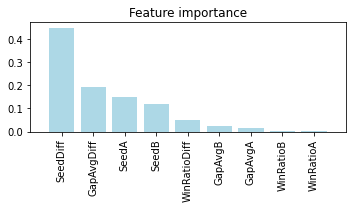

In [ ]:
#特徴量の重要度

tree_feature_importances = (
    clf.feature_importances_)

print(tree_feature_importances)

#特徴量の重要度を上から順に出力する

f = pd.DataFrame({'number':range(0, len(tree_feature_importances)), 'tree_feature_importances':tree_feature_importances[:]})

f2 = f.sort_values('tree_feature_importances', ascending=False)

#特徴量の名前

label = X_year.columns[0:]

#特徴量の重要度順（降順）

indices = np.argsort(tree_feature_importances)[::-1]

# 特徴量別の寄与度を表示

for i in range(len(tree_feature_importances)):
  print(str(i+1) + " " + str(label[indices[i]]) + " " + str(tree_feature_importances[indices[i]]))

# 特徴量別の寄与度をグラフ描画

plt.title('Feature importance')
plt.bar(range(len(tree_feature_importances)), tree_feature_importances[indices], color='lightblue', align='center')
plt.xticks(range(len(tree_feature_importances)), label[indices], rotation=90)
plt.xlim([-1, len(tree_feature_importances)])
plt.tight_layout()
plt.show()

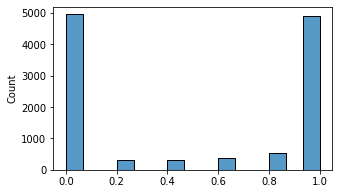

In [ ]:
_ = sns.histplot(test_pred)

In [ ]:
# 提出

sub = test[['ID', 'Pred']].copy()
sub['Pred'] = test_pred
sub.to_csv('submission.csv', index=False)



In [ ]:

from google.colab import files
sub.to_csv("output.csv")
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>